# Apple Health Visualization Consumation
  * BloodAlcoholContent
  * DietaryCaffeine
  * DietaryWater

## Setup

### Import sub-modules

In [1]:
# python
import sys
import os
import datetime
import enum

# iPython
import IPython
from IPython.display import display
from IPython.display import Image

# pandas
import pandas as pd

# numpy
import numpy as np

# plotly
import plotly as ply
import plotly.figure_factory as ff
ply.offline.init_notebook_mode(connected=True)
import plotly.io as pio

# watermark
import watermark
%load_ext watermark
%watermark -a "Silvan Zahno" -d -v -iv -m -h

plotly    3.8.1
pandas    0.24.2
numpy     1.16.2
watermark 1.8.1
IPython   7.4.0
Silvan Zahno 2019-07-03 

CPython 3.7.3
IPython 7.4.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores  : 8
interpreter: 64bit
host name  : WE6996


### Configuration

In [2]:
# Setup local input directories
inputDir = "in/"

if (os.path.exists(inputDir)) is False:
    os.makedirs(inputDir)
if (os.path.isdir(inputDir)) is False:
    raise NotADirectoryError("{} is not a directory".format(inputDir))

In [3]:
# Setup local input directories
outputDir = "out/"

if (os.path.exists(outputDir)) is False:
    os.makedirs(outputDir)
if (os.path.isdir(outputDir)) is False:
    raise NotADirectoryError("{} is not a directory".format(outputDir))

In [4]:
# Graph output Options
class GraphOutputOption(enum.Enum):
    none = 'none'                     # Do not generate any plots
    inline = 'inline'                 # Generate inline plots only
    htmlFile = 'extFile'              # Generate plots in external files (html or png or ...)
    both = 'both'                     # Generate all plots inline and external
    
class GraphInteractionOption(enum.Enum):
    static = 'static'                 # Generate static inline plots (as images)
    interactive = 'interactive'       # Generate interactive inline plots

notebookGraphingInteraction = GraphInteractionOption('interactive')
notebookGraphingOutputs = GraphOutputOption('both')

ext_file = ".svg"

staticImageSize = {'width':1000, 'height':500, 'scale':1}

GraphAutoOpenHTML = False              # Auto open external HTML files [True/False]

class PrintOutputOption(enum.Enum):
    none = 'none'                     # Do not output either to file or console
    console = 'console'               # Send to console
    file = 'file'                     # Send to file
    both = 'both'                     # Send to console and file


In [5]:
# Pandas output options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

### Common functions

In [6]:
# Plot figures
def plot_figure(graphFilename, fig, overrideNotebookGraphingInteraction=None, height=350):
    """Creates the graph plots depending on the choosen option

    Args:
        graphFilename: Filename of the output html-file in case of Option htmlfile
        fig: ply.graph_objs.Figure(data=traces, layout=mylayout)
        overrideNotebookGraphingInteraction: overrides graphic output for this figure
        height: height of the static image export
    Returns:
        None
    Raises:
        None

    """
    if (notebookGraphingOutputs == GraphOutputOption('extFile')) or (notebookGraphingOutputs == GraphOutputOption('both')):
        if (os.path.splitext(graphFilename)[1] == '.png' or 
           os.path.splitext(graphFilename)[1] == '.jpg' or 
           os.path.splitext(graphFilename)[1] == '.svg' or 
           os.path.splitext(graphFilename)[1] == '.pdf'):
            pio.write_image(fig, graphFilename, height=height)
        elif os.path.splitext(graphFilename)[1] == '.html':
            ply.offline.plot(fig, filename=graphFilename, auto_open=GraphAutoOpenHTML)
    if (notebookGraphingOutputs == GraphOutputOption('inline')) or (notebookGraphingOutputs == GraphOutputOption('both')):
        choice = None
        if overrideNotebookGraphingInteraction == None:
            if notebookGraphingInteraction == GraphInteractionOption('static'):
                choice = 'static'
            elif notebookGraphingInteraction == GraphInteractionOption('interactive'):
                choice = 'interactive'
        elif overrideNotebookGraphingInteraction == GraphInteractionOption('static'):
            choice = 'static'
        elif overrideNotebookGraphingInteraction == GraphInteractionOption('interactive'):
            choice = 'interactive'
        else:
            choice = 'static'
            
        if choice == 'static':
            plot_img = pio.to_image(fig, format='png', width=staticImageSize['width'], height=staticImageSize['height'], scale=staticImageSize['scale'])
            display(Image(plot_img))
        else:
            ply.offline.iplot(fig)
            

In [7]:
def print_file(text="", file=None, outputOption=PrintOutputOption('console'), append=True):
    """Custom print function to print to console and/or file

    Args:
        text: String to be used
        file: output file path for fileoutput
        fileoutput: bool sends string to file
        consoleoutput: PrintOutputOption to specify where to send the string
        append: For fileoutput only, create new file or append to existing
    Returns:
        None
    Raises:
        None
    """
    if (outputOption == PrintOutputOption('file') or outputOption == PrintOutputOption('both')):
        if append:
            with open(file, "a+") as file:
                file.write(text+"\n")#os.linesep)
        else:
            with open(file, "w+") as file:
                file.write(text+"\n")#os.linesep)
    if (outputOption == PrintOutputOption('console') or outputOption == PrintOutputOption('both')):
        print(text)

In [8]:
def value_stats(measurement):
    print("\n{}".format(df_description[measurement]))
    print("  * Time between {} - {}".format(dfs[df_list[measurement]].startDate.iat[0], dfs[df_list[measurement]].startDate.iat[-1]))
    print("  * Measured by {}".format(dfs[df_list[measurement]].sourceName.iat[0]))
    print("  * {} measurements".format(len(dfs[df_list[measurement]].value)))
    print("  * Total {} {}".format(dfs[df_list[measurement]].value.sum(), dfs[df_list[measurement]].unit.iat[0]))    

In [22]:
def plot_value_vs_time(df, measurement = None, rolling_mean = 3):
    # plot value vs time
    # .. prepare traces
    trace_value = ply.graph_objs.Scatter(
        x=df.index,
        y=df.value,
        mode='markers',
        name=df_description[measurement],
    )
    
    # .. add a rolling mean to data
    trace_value_mean = ply.graph_objs.Scatter(
        x=df.index,
        y=df.value.rolling(3).mean(),
        mode='lines',
        name="{} Rolling Mean".format(df_description[measurement]),
    )
    
    # .. set layout
    mylayout = ply.graph_objs.Layout(
        title="{} vs Time".format(df_description[measurement]),
        yaxis=dict(
            title="{} [{}]".format(df_description[measurement], df.unit[0])
        )
    )
    
    # .. set data to plot
    traces = [trace_value, trace_value_mean]
    
    # .. plot
    graphFilename = outputDir + mylayout.title.text + ' - Scatter vs Time.html'
    fig = ply.graph_objs.Figure(data=traces, layout=mylayout)
    plot_figure(graphFilename, fig)

## Data import

In [23]:
df_list = {
'energy': 0,
'alcohol': 1,
'fat': 2,
'weight': 3,
'bmi': 4,
'caffeine': 5,
'water': 6,
'cycling': 7,
'walking': 8,
'flightsclimbed': 9,
'heartrate': 10,
'height': 11,
'sleep': 12,
'steps': 13,
'workout': 14
}
df_description = {
'energy': "Active Energy Burned",
'alcohol': "Blood Alcohol Content",
'fat': "Body Fat Percentage",
'weight': "Body Mass",
'bmi': "Body Mass Index",
'caffeine': "Dietary Caffeine",
'water': "Dietary Water",
'cycling': "Distance Cycling",
'walking': "Distance Walink & Running",
'flightsclimbed': "Number of Flights Climbed",
'heartrate': "Heart Rate",
'height': "Height",
'sleep': "Sleep Analysis",
'steps': "Step Count",
'workout': "Workout"
}
dfs = []
dfs.append(pd.read_csv(inputDir + "ActiveEnergyBurned.csv"))
dfs.append(pd.read_csv(inputDir + "BloodAlcoholContent.csv"))
dfs.append(pd.read_csv(inputDir + "BodyFatPercentage.csv"))
dfs.append(pd.read_csv(inputDir + "BodyMass.csv"))
dfs.append(pd.read_csv(inputDir + "BodyMassIndex.csv"))
dfs.append(pd.read_csv(inputDir + "DietaryCaffeine.csv"))
dfs.append(pd.read_csv(inputDir + "DietaryWater.csv"))
dfs.append(pd.read_csv(inputDir + "DistanceCycling.csv"))
dfs.append(pd.read_csv(inputDir + "DistanceWalkingRunning.csv"))
dfs.append(pd.read_csv(inputDir + "FlightsClimbed.csv"))
dfs.append(pd.read_csv(inputDir + "HeartRate.csv"))
dfs.append(pd.read_csv(inputDir + "Height.csv"))
dfs.append(pd.read_csv(inputDir + "SleepAnalysis.csv"))
dfs.append(pd.read_csv(inputDir + "StepCount.csv"))
dfs.append(pd.read_csv(inputDir + "Workout.csv"))

## Visualization

### Alcohol

In [25]:
measurement = 'alcohol'
dfs[df_list[measurement]]['creationDate'] =  pd.to_datetime(dfs[df_list[measurement]]['creationDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]]['startDate'] =  pd.to_datetime(dfs[df_list[measurement]]['startDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]]['endDate'] =  pd.to_datetime(dfs[df_list[measurement]]['endDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]].set_index('creationDate', inplace=True)


Blood Alcohol Content
  * Time between 2019-01-22 09:52:00+00:00 - 2019-01-23 12:06:00+00:00
  * Measured by Shortcuts
  * 4 measurements
  * Total 1.0 %


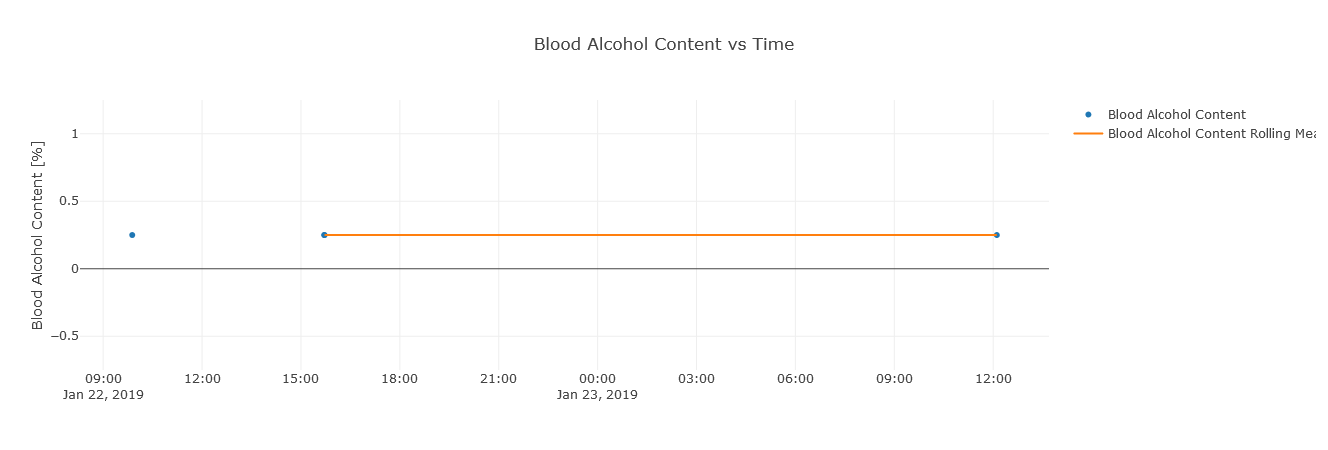

In [26]:
value_stats(measurement)
plot_value_vs_time(dfs[df_list[measurement]], measurement)

### Caffeine

In [27]:
measurement = 'caffeine'
dfs[df_list[measurement]]['creationDate'] =  pd.to_datetime(dfs[df_list[measurement]]['creationDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]]['startDate'] =  pd.to_datetime(dfs[df_list[measurement]]['startDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]]['endDate'] =  pd.to_datetime(dfs[df_list[measurement]]['endDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]].set_index('creationDate', inplace=True)


Dietary Caffeine
  * Time between 2019-01-25 20:24:00+00:00 - 2019-01-26 12:10:00+00:00
  * Measured by Shortcuts
  * 4 measurements
  * Total 20.959999999999997 mg


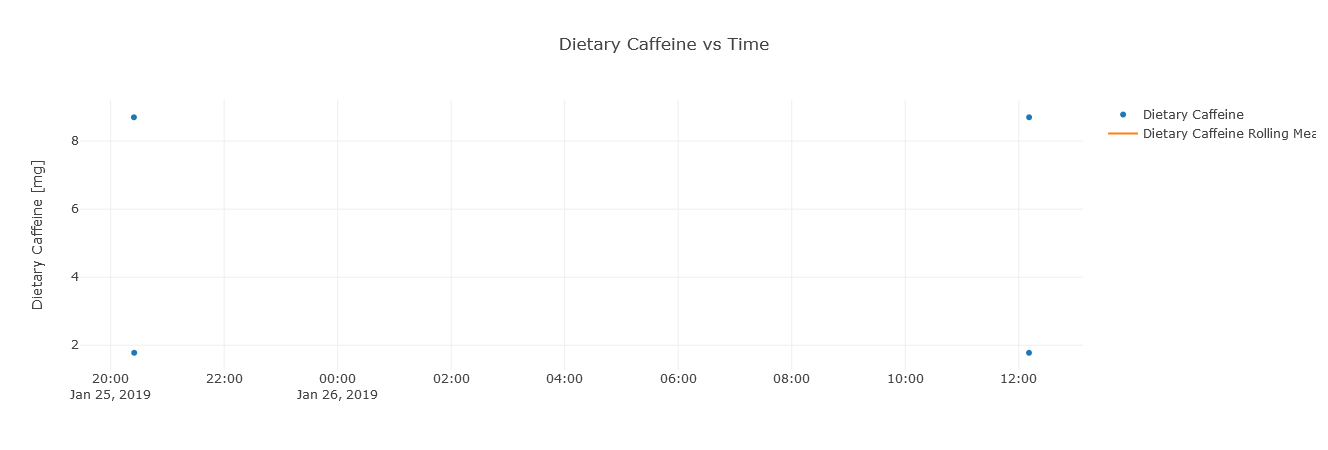

In [28]:
value_stats(measurement)
plot_value_vs_time(dfs[df_list[measurement]], measurement)

### Water

In [29]:
measurement = 'water'
dfs[df_list[measurement]]['creationDate'] =  pd.to_datetime(dfs[df_list[measurement]]['creationDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]]['startDate'] =  pd.to_datetime(dfs[df_list[measurement]]['startDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]]['endDate'] =  pd.to_datetime(dfs[df_list[measurement]]['endDate'], format='%Y-%m-%d %H:%M:%S', utc=True)
dfs[df_list[measurement]].set_index('creationDate', inplace=True)


Dietary Water
  * Time between 2019-01-21 19:04:00+00:00 - 2019-01-28 07:21:00+00:00
  * Measured by Shortcuts
  * 18 measurements
  * Total 6.199999999999999 L


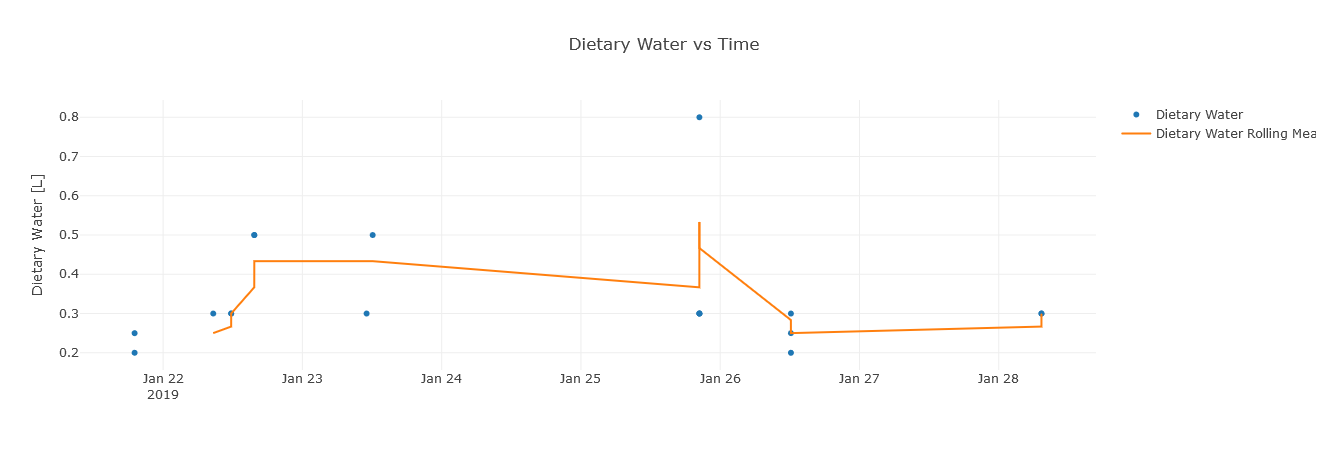

In [30]:
value_stats(measurement)
plot_value_vs_time(dfs[df_list[measurement]], measurement)